In [1]:
from fetch import fetch_data
from config import TICKER_CL, TICKER_OVX, START
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw = fetch_data()

def log_returns(df, column = 'cl_close'):
    copy = df.copy()
    copy['log_returns'] = np.log(copy[column] / copy[column].shift(1))
    return copy

stage1_df = log_returns(raw)

stage1_df

c:\Users\Will\Downloads\Python\CTA Forecast\fetch.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  cl_data = yf.download(TICKER_CL, start=start)[['Close', 'Volume']].rename(columns = {'Close': 'cl_close', 'Volume': 'cl_volume'})
[*********************100%***********************]  1 of 1 completed
c:\Users\Will\Downloads\Python\CTA Forecast\fetch.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ovx_data = yf.download(TICKER_OVX, start=start)[['Close']].rename(columns = {'Close': 'ovx_close'})
[*********************100%***********************]  1 of 1 completed
c:\Users\Will\Downloads\Python\CTA Forecast\cta_venv\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Price,cl_close,cl_volume,ovx_close,log_returns
Ticker,CL=F,CL=F,^OVX,
Date,,,,
2010-01-04,81.510002,263542.0,35.439999,NaN
2010-01-05,81.769997,258887.0,34.270000,0.003185
2010-01-06,83.180000,370059.0,34.400002,0.017097
2010-01-07,82.660004,246632.0,33.610001,-0.006271
2010-01-08,82.750000,310377.0,31.340000,0.001088
...,...,...,...,...
2025-09-08,62.259998,237288.0,35.029999,0.006284
2025-09-09,62.630001,268529.0,33.439999,0.005925


In [2]:
def historic_signal(df, lookback = (20, 60, 120)):
    copy = df.copy()
    for lb in lookback:
        col_name = f'signal_{lb}'
        numerator = copy['log_returns'].rolling(lb).sum()
        denominator = copy['log_returns'].rolling(lb).std() * np.sqrt(lb)
        copy[col_name] = numerator / denominator

    # averaging each signal
    copy['signal'] = copy[[f'signal_{lb}' for lb in lookback]].mean(axis = 1)
    return copy

stage2_df = historic_signal(stage1_df).dropna()

stage2_df

Price,cl_close,cl_volume,ovx_close,log_returns,signal_20,signal_60,signal_120,signal
Ticker,CL=F,CL=F,^OVX,,,,,
Date,,,,,,,,
2010-06-25,78.860001,316456.0,35.820000,0.030253,0.663350,-0.380047,-0.161270,0.040678
2010-06-28,78.250000,223305.0,36.709999,-0.007765,0.663930,-0.513692,-0.214588,-0.021450
2010-06-29,75.940002,323267.0,39.160000,-0.029965,0.512309,-0.827254,-0.441185,-0.252044
2010-06-30,75.629997,357752.0,39.500000,-0.004091,0.421426,-0.869258,-0.430720,-0.292850
2010-07-01,72.949997,405081.0,41.220001,-0.036079,-0.241741,-1.005190,-0.602095,-0.616342
...,...,...,...,...,...,...,...,...
2025-09-08,62.259998,237288.0,35.029999,0.006284,-0.362527,-0.503580,-0.319610,-0.395239
2025-09-09,62.630001,268529.0,33.439999,0.005925,-0.295194,-0.461176,-0.257186,-0.337852


In [3]:
def realized_vol(df, returns_col = 'log_returns', lookback = 21):
    copy = df.copy()
    copy['realized_vol'] = copy[returns_col].rolling(lookback).std() * np.sqrt(252)
    return copy

stage2_df = realized_vol(stage2_df).dropna()

In [4]:
# Using realized vol to calculate historic position sizing

def position_history(df, signal_col = 'signal', ovx_col = 'ovx_close', lookback = 3500):
    copy = df.copy()
    copy['raw_position'] = copy['signal'] / realized_vol(copy)['realized_vol']
    copy['historic_max_position'] = copy['raw_position'].abs().rolling(lookback, min_periods = 252).max().replace(0, np.nan).ffill()
    copy['weighted_position'] = copy['raw_position'] / copy['historic_max_position']
    copy['weighted_position'] = copy['weighted_position'].clip(-1, 1)
    copy['daily_flow'] = copy['weighted_position'].diff()
    return copy

stage3_df = position_history(stage2_df).dropna()

stage3_df

Price,cl_close,cl_volume,ovx_close,log_returns,signal_20,signal_60,signal_120,signal,realized_vol,raw_position,historic_max_position,weighted_position,daily_flow
Ticker,CL=F,CL=F,^OVX,,,,,,,,,,
Date,,,,,,,,,,,,,
2011-08-22,84.120003,374045.0,52.400002,0.022359,-1.227847,-0.982203,-0.786465,-0.998838,0.464659,-2.149617,7.392500,-0.290784,0.049918
2011-08-23,85.440002,353947.0,47.669998,0.015570,-1.127639,-0.910709,-0.709329,-0.915892,0.471896,-1.940877,7.392500,-0.262547,0.028237
2011-08-24,85.160004,294928.0,47.889999,-0.003283,-0.994178,-1.054234,-0.824962,-0.957791,0.470431,-2.035986,7.392500,-0.275412,-0.012866
2011-08-25,85.300003,357816.0,51.419998,0.001643,-0.984518,-0.917448,-0.858497,-0.920154,0.468244,-1.965116,7.392500,-0.265826,0.009587
2011-08-26,85.370003,283261.0,48.119999,0.000820,-0.847357,-0.919042,-0.838998,-0.868466,0.468321,-1.854426,7.392500,-0.250852,0.014973
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-08,62.259998,237288.0,35.029999,0.006284,-0.362527,-0.503580,-0.319610,-0.395239,0.245185,-1.612002,18.437302,-0.087432,-0.010619
2025-09-09,62.630001,268529.0,33.439999,0.005925,-0.295194,-0.461176,-0.257186,-0.337852,0.246414,-1.371074,18.437302,-0.074364,0.013067


In [ ]:
def position_forecast(df, signal_col = 'signal', ovx_col = 'ovx_close'):
    copy = df.copy()
    

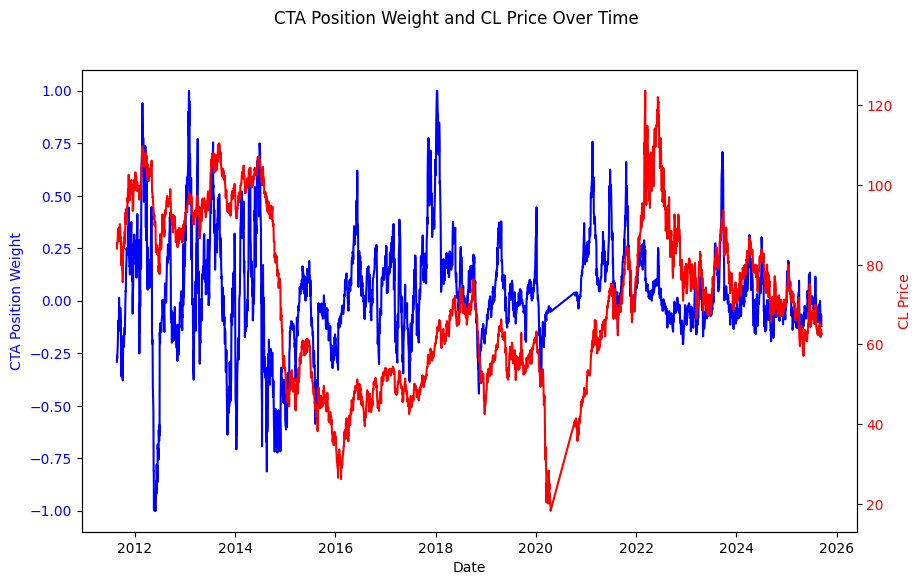

In [5]:
fig, ax1 = plt.subplots(figsize = (10, 6))
ax2 = ax1.twinx()

ax1.plot(stage3_df.index, stage3_df['weighted_position'], color = 'blue')
ax2.plot(stage3_df.index, stage3_df['cl_close'], color = 'red')

ax1.set_xlabel('Date')
ax1.set_ylabel('CTA Position Weight', color = 'blue')
ax1.tick_params(axis = 'y', labelcolor = 'blue')

ax2.set_ylabel('CL Price', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')

fig.suptitle('CTA Position Weight and CL Price Over Time')

plt.show()